# How to Use Anomaly Detectors in Merlion

This notebook will guide you through using all the key features of anomaly detectors in Merlion. Specifically, we will explain

1. Initializing an anomaly detection model (including ensembles)
1. Training the model
1. Producing a series of anomaly scores with the model
1. Quantitatively evaluating the model
1. Visualizing the model's predictions
1. Saving and loading a trained model
1. Simulating the live deployment of a model using a `TSADEvaluator`

We will be using a single example time series for this whole notebook. We load and visualize it now:

plotly not installed, so plotly visualizations will not work.
Time series /Users/pkassianik/research/MerlionPublic/data/nab/realKnownCause/ec2_request_latency_system_failure.csv (index 2) has timestamp duplicates. Kept first values.
Time series /Users/pkassianik/research/MerlionPublic/data/nab/realKnownCause/machine_temperature_system_failure.csv (index 3) has timestamp duplicates. Kept first values.


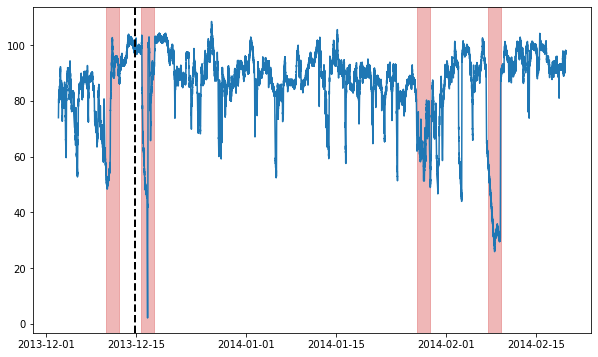

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from merlion.plot import plot_anoms
from merlion.utils import TimeSeries
from ts_datasets.anomaly import NAB

np.random.seed(1234)

# This is a time series with anomalies in both the train and test split.
# time_series and metadata are both time-indexed pandas DataFrames.
time_series, metadata = NAB(subset="realKnownCause")[3]

# Visualize the full time series
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time_series)

# Label the train/test split with a dashed line & plot anomalies
ax.axvline(metadata[metadata.trainval].index[-1], ls="--", lw=2, c="k")
plot_anoms(ax, TimeSeries.from_pd(metadata.anomaly))

In [2]:
from merlion.utils import TimeSeries

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

## Model Initialization

In this notebook, we will use three different anomaly detection models:

1. Isolation Forest (a classic anomaly detection model)
2. WindStats (an in-house model that divides each week into windows of a specified size, and compares time series values to the historical values in the appropriate window)
3. Prophet (Facebook's popular forecasting model, adapted for anomaly detection.

Let's start by initializing each of them:

In [3]:
# Import models & configs
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig
from merlion.models.anomaly.windstats import WindStats, WindStatsConfig
from merlion.models.anomaly.forecast_based.prophet import ProphetDetector, ProphetDetectorConfig

# Import a post-rule for thresholding
from merlion.post_process.threshold import AggregateAlarms

# Import a data processing transform
from merlion.transform.moving_average import DifferenceTransform

# All models are initialized using the syntax ModelClass(config), where config
# is a model-specific configuration object. This is where you specify any
# algorithm-specific hyperparameters, any data pre-processing transforms, and
# the post-rule you want to use to post-process the anomaly scores (to reduce
# noisiness when firing alerts). 

# We initialize isolation forest using the default config
config1 = IsolationForestConfig()
model1  = IsolationForest(config1)

# We use a WindStats model that splits each week into windows of 60 minutes
# each. Anomaly scores in Merlion correspond to z-scores. By default, we would
# like to fire an alert for any 4-sigma event, so we specify a threshold rule
# which achieves this.
config2 = WindStatsConfig(wind_sz=60, threshold=AggregateAlarms(alm_threshold=4))
model2  = WindStats(config2)

# Prophet is a popular forecasting algorithm. Here, we specify that we would like
# to pre-processes the input time series by applying a difference transform,
# before running the model on it.
config3 = ProphetDetectorConfig(transform=DifferenceTransform())
model3  = ProphetDetector(config3)

Importing plotly failed. Interactive plots will not work.


Now that we have initialized the individual models, we will also combine them in an ensemble. We set this ensemble's detection threshold to fire alerts for 4-sigma events (the same as WindStats).

In [4]:
from merlion.models.ensemble.anomaly import DetectorEnsemble, DetectorEnsembleConfig

ensemble_config = DetectorEnsembleConfig(threshold=AggregateAlarms(alm_threshold=4))
ensemble = DetectorEnsemble(config=ensemble_config, models=[model1, model2, model3])

## Model Training

All anomaly detection models (and ensembles) share the same API for training. The `train()` method returns the model's predicted anomaly scores on the training data. Note that you may optionally specify configs that modify the protocol used to train the model's post-rule! You may optionally specify ground truth anomaly labels as well (if you have them), but they are not needed. We give examples of all these behaviors below.

In [5]:
from merlion.evaluate.anomaly import TSADMetric

# Train IsolationForest in the default way, using the ground truth anomaly labels
# to set the post-rule's threshold
print(f"Training {type(model1).__name__}...")
train_scores_1 = model1.train(train_data=train_data, anomaly_labels=train_labels)

# Train WindStats completely unsupervised (this retains our anomaly detection 
# default anomaly detection threshold of 4)
print(f"\nTraining {type(model2).__name__}...")
train_scores_2 = model2.train(train_data=train_data, anomaly_labels=None)

# Train Prophet with the ground truth anomaly labels, with a post-rule
# trained to optimize Precision score
print(f"\nTraining {type(model3).__name__}...")
post_rule_train_config_3 = dict(metric=TSADMetric.F1)
train_scores_3 = model3.train(
    train_data=train_data, anomaly_labels=train_labels,
    post_rule_train_config=post_rule_train_config_3)

# We consider an unsupervised ensemble, which combines the anomaly scores
# returned by the models & sets a static anomaly detection threshold of 3.
print("\nTraining ensemble...")
ensemble_post_rule_train_config = dict(metric=None)
train_scores_e = ensemble.train(
    train_data=train_data, anomaly_labels=train_labels,
    post_rule_train_config=ensemble_post_rule_train_config,
)

print("Done!")

Training IsolationForest...


INFO:merlion.post_process.threshold:Threshold 3.2263 achieves F1=0.5000.
INFO:merlion.models.forecast.prophet:Add seasonality 15
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.



Training WindStats...

Training ProphetDetector...


INFO:merlion.post_process.threshold:Threshold 3.2263 achieves F1=0.6667.



Training ensemble...


INFO:merlion.models.forecast.prophet:Add seasonality 15
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Done!


## Model Inference

There are two ways to invoke an anomaly detection model: `model.get_anomaly_score()` returns the model's raw anomaly scores, while `model.get_anomaly_label()` returns the model's post-processed anomaly scores. The post-processing calibrates the anomaly scores to be interpretable as z-scores, and it also sparsifies them such that any nonzero values should be treated as an alert that a particular timestamp is anomalous.

In [6]:
# Here is a full example for the first model, IsolationForest
scores_1 = model1.get_anomaly_score(test_data)
scores_1_df = scores_1.to_pd()
print(f"{type(model1).__name__}.get_anomaly_score() nonzero values (raw)")
print(scores_1_df[scores_1_df.iloc[:, 0] != 0])
print()

labels_1 = model1.get_anomaly_label(test_data)
labels_1_df = labels_1.to_pd()
print(f"{type(model1).__name__}.get_anomaly_label() nonzero values (post-processed)")
print(labels_1_df[labels_1_df.iloc[:, 0] != 0])
print()

print(f"{type(model1).__name__} fires {(labels_1_df.values != 0).sum()} alarms")
print()

print("Raw scores at the locations where alarms were fired:")
print(scores_1_df[labels_1_df.iloc[:, 0] != 0])
print("Post-processed scores are interpretable as z-scores")
print("Raw scores are challenging to interpret")

IsolationForest.get_anomaly_score() nonzero values (raw)
                     anom_score
2013-12-14 16:55:00    0.424103
2013-12-14 17:00:00    0.418938
2013-12-14 17:05:00    0.484891
2013-12-14 17:10:00    0.500257
2013-12-14 17:15:00    0.449213
...                         ...
2014-02-19 15:05:00    0.419456
2014-02-19 15:10:00    0.415807
2014-02-19 15:15:00    0.406724
2014-02-19 15:20:00    0.427094
2014-02-19 15:25:00    0.428348

[19279 rows x 1 columns]

IsolationForest.get_anomaly_label() nonzero values (post-processed)
                     anom_score
2013-12-16 16:00:00    3.251397
2013-12-16 18:35:00    3.681691
2013-12-27 19:25:00    3.914430
2013-12-27 23:20:00    3.260543
2013-12-28 04:15:00    3.738462
2013-12-28 06:20:00    3.303482
2014-01-02 10:00:00    3.233514
2014-01-05 17:50:00    3.791805
2014-01-12 09:25:00    3.535895
2014-01-13 10:05:00    3.314500
2014-01-16 12:50:00    3.850349
2014-01-24 12:50:00    4.170855
2014-01-27 17:45:00    3.537919
2014-01-28 22:00

The same API is shared for all models, including ensembles.

In [7]:
scores_2 = model2.get_anomaly_score(test_data)
labels_2 = model2.get_anomaly_label(test_data)

In [8]:
scores_3 = model3.get_anomaly_score(test_data)
labels_3 = model3.get_anomaly_label(test_data)

In [9]:
scores_e = ensemble.get_anomaly_score(test_data)
labels_e = ensemble.get_anomaly_label(test_data)

## Quantitative Evaluation

It is fairly transparent to visualize a model's predicted anomaly scores and also quantitatively evaluate its anomaly labels. For evaluation, we use specialized definitions of precision, recall, and F1 as revised point-adjusted metrics (see the technical report for more details). We also consider the mean time to detect anomalies.

In general, you may use the `TSADMetric` enum to compute evaluation metrics for a time series using the syntax
```
TSADMetric.<metric_name>.value(ground_truth=ground_truth, predict=anomaly_labels)
```
where `<metric_name>` is the name of the evaluation metric (see the API docs for details and more options), `ground_truth` is a time series of ground truth anomaly labels, and `anomaly_labels` is the output of `model.get_anomaly_label()`.

In [10]:
from merlion.evaluate.anomaly import TSADMetric

for model, labels in [(model1, labels_1), (model2, labels_2), (model3, labels_3), (ensemble, labels_e)]:
    print(f"{type(model).__name__}")
    precision = TSADMetric.Precision.value(ground_truth=test_labels, predict=labels)
    recall = TSADMetric.Recall.value(ground_truth=test_labels, predict=labels)
    f1 = TSADMetric.F1.value(ground_truth=test_labels, predict=labels)
    mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels, predict=labels)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"MTTD:      {mttd}")
    print()

IsolationForest
Precision: 0.1667
Recall:    1.0000
F1:        0.2857
MTTD:      0 days 23:31:40

WindStats
Precision: 0.2500
Recall:    0.6667
F1:        0.3636
MTTD:      1 days 10:25:00

ProphetDetector
Precision: 0.3000
Recall:    1.0000
F1:        0.4615
MTTD:      1 days 00:03:20

DetectorEnsemble
Precision: 0.4000
Recall:    0.6667
F1:        0.5000
MTTD:      1 days 10:25:00



Since the individual models are trained to optimize F1 directly, they all have low precision, high recall, and a mean time to detect of around 1 day. However, by instead training the individual models to optimize precision, and training a model combination unit to optimize F1, we are able to greatly increase the precision and F1 score, at the cost of a lower recall and higher mean time to detect.

## Model Visualization

Let's now visualize the model predictions that led to these outcomes. The option `filter_scores=True` means that we want to plot the post-processed anomaly scores (i.e. returned by `model.get_anomaly_label()`). You may instead specify `filter_scores=False` to visualize the raw anomaly scores.

IsolationForest


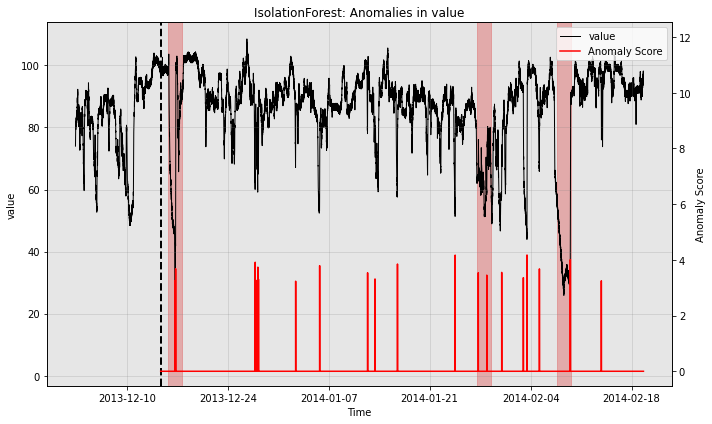


WindStats


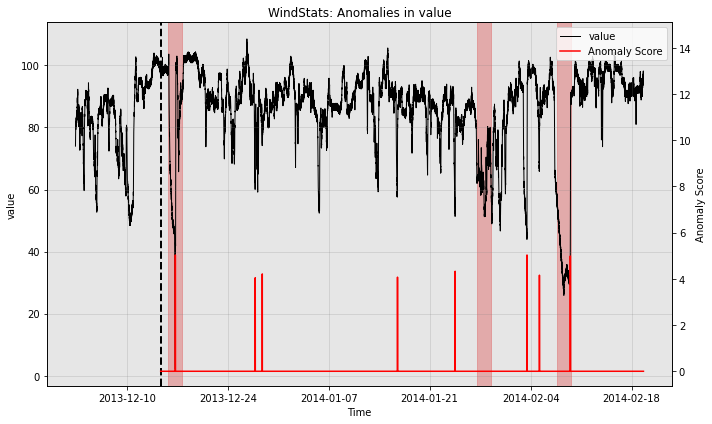


ProphetDetector


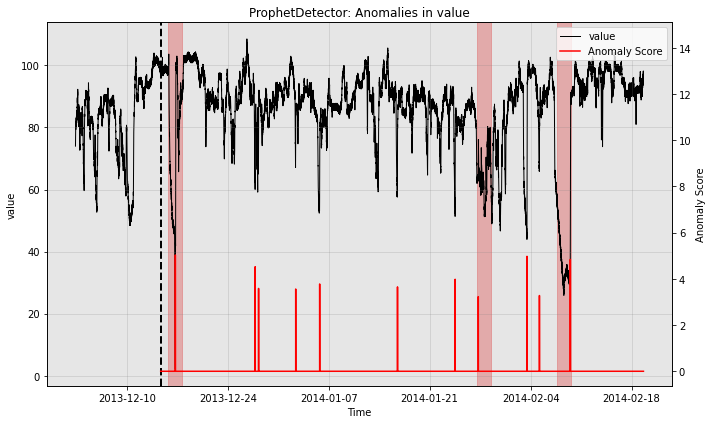

In [11]:
for model in [model1, model2, model3]:
    print(type(model).__name__)
    fig, ax = model.plot_anomaly(
        time_series=test_data, time_series_prev=train_data,
        filter_scores=True, plot_time_series_prev=True)
    plot_anoms(ax=ax, anomaly_labels=test_labels)
    plt.show()
    print()

So all the individual models generate quite a few false positives. Let's see how the ensemble does:

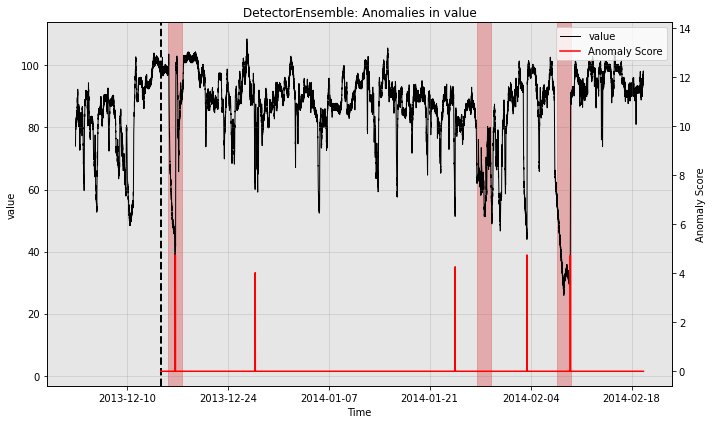

In [12]:
fig, ax = ensemble.plot_anomaly(
    time_series=test_data, time_series_prev=train_data,
    filter_scores=True, plot_time_series_prev=True)
plot_anoms(ax=ax, anomaly_labels=test_labels)
plt.show()

So the ensemble misses one of the three anomalies in the test split, but it also greatly reduces the number of false positives relative to the other models.

## Saving & Loading Models

All models have a `save()` method and `load()` class method. Models may also be loaded with the assistance of the `ModelFactory`, which works for arbitrary models. The `save()` method creates a new directory at the specified path, where it saves a `json` file representing the model's config, as well as a binary file for the model's state.

We will demonstrate these behaviors using our `IsolationForest` model (`model1`) for concreteness. Note that the config explicitly tracks the transform (to pre-process the data), the calibrator (to transform raw anomaly scores into z-scores), the thresholding rule (to sparsify the calibrated anomaly scores).

In [13]:
import json
import os
import pprint
from merlion.models.factory import ModelFactory

# Save the model
os.makedirs("models", exist_ok=True)
path = os.path.join("models", "isf")
model1.save(path)

# Print the config saved
pp = pprint.PrettyPrinter()
with open(os.path.join(path, "config.json")) as f:
    print(f"{type(model1).__name__} Config")
    pp.pprint(json.load(f))

# Load the model using Prophet.load()
model2_loaded = IsolationForest.load(dirname=path)

# Load the model using the ModelFactory
model2_factory_loaded = ModelFactory.load(name="IsolationForest", model_path=path)

IsolationForest Config
{'calibrator': {'abs_score': True,
                'anchors': [[0.38992633996347176, 0.0],
                            [0.4187750781361715, 0.5],
                            [0.445336977389891, 1.0],
                            [0.47974261897360404, 1.5],
                            [0.5271631189090943, 2.0],
                            [0.8301789920204418, 4.032894437734716],
                            [1.0, 5.032894437734716]],
                'max_score': 1.0,
                'name': 'AnomScoreCalibrator'},
 'enable_calibrator': True,
 'enable_threshold': True,
 'max_n_samples': 1.0,
 'model_path': '/Users/pkassianik/research/MerlionPublic/examples/anomaly/models/isf/model.pkl',
 'n_estimators': 100,
 'threshold': {'abs_score': True,
               'alm_suppress_minutes': 120,
               'alm_threshold': 3.2263155501877727,
               'alm_window_minutes': 60,
               'min_alm_in_window': 2,
               'name': 'AggregateAlarms'},
 'transfor

We can do the same exact thing with ensembles! Note that the ensemble saves each of its sub-models in a different sub-directory, which it tracks manually.

In [14]:
# Save the ensemble
path = os.path.join("models", "ensemble")
ensemble.save(path)

# Print the config saved. Note that we've saved all individual models,
# and their paths are specified under the model_paths key.
pp = pprint.PrettyPrinter()
with open(os.path.join(path, "config.json")) as f:
    print(f"Ensemble Config")
    pp.pprint(json.load(f))

# Load the selector
selector_loaded = DetectorEnsemble.load(dirname=path)

# Load the selector using the ModelFactory
selector_factory_loaded = ModelFactory.load(name="DetectorEnsemble", model_path=path)

Ensemble Config
{'calibrator': {'abs_score': True,
                'anchors': None,
                'max_score': 1000,
                'name': 'AnomScoreCalibrator'},
 'combiner': {'abs_score': True, 'n_models': 3, 'name': 'Mean'},
 'enable_calibrator': False,
 'enable_threshold': True,
 'model_paths': [['IsolationForest',
                  '/Users/pkassianik/research/MerlionPublic/examples/anomaly/models/ensemble/0'],
                 ['WindStats',
                  '/Users/pkassianik/research/MerlionPublic/examples/anomaly/models/ensemble/1'],
                 ['ProphetDetector',
                  '/Users/pkassianik/research/MerlionPublic/examples/anomaly/models/ensemble/2']],
 'threshold': {'abs_score': True,
               'alm_suppress_minutes': 120,
               'alm_threshold': 4,
               'alm_window_minutes': 60,
               'min_alm_in_window': 2,
               'name': 'AggregateAlarms'},
 'transform': {'name': 'Identity'}}


## Simulating Live Model Deployment

A typical model deployment scenario is as follows:
1. Train an initial model on some recent historical data, optionally with labels.
1. At a regular interval `retrain_freq` (e.g. once per week), retrain the entire model unsupervised (i.e. with no labels) on the most recent data.
1. Obtain the model's predicted anomaly scores for the time series values that occur between re-trainings. We perform this operation in batch, but a deployment scenario may do this in streaming.
1. Optionally, specify a maximum amount of data (`train_window`) that the model should use for training (e.g. the most recent 2 weeks of data).

We provide a `TSADEvaluator` object which simulates the above deployment scenario, and also allows a user to evaluate the quality of the forecaster according to an evaluation metric of their choice. We illustrate an example below using the ensemble.

In [15]:
# Initialize the evaluator
from merlion.evaluate.anomaly import TSADEvaluator, TSADEvaluatorConfig

evaluator = TSADEvaluator(model=ensemble, config=TSADEvaluatorConfig(retrain_freq="7d"))

In [16]:
# The kwargs we would provide to ensemble.train() for the initial training
# Note that we are training the ensemble unsupervised.
train_kwargs = {"anomaly_labels": None}

# We will use the default kwargs for re-training (these leave the
# post-rules unchanged, since there are no new labels)
retrain_kwargs = None

# We call evaluator.get_predict() to get the time series of anomaly scores
# produced by the anomaly detector when deployed in this manner
train_scores, test_scores = evaluator.get_predict(
    train_vals=train_data, test_vals=test_data,
    train_kwargs=train_kwargs, retrain_kwargs=retrain_kwargs
)

INFO:merlion.models.forecast.prophet:Add seasonality 15
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
TSADEvaluator:  10%|█         | 604800/5783700 [00:00<00:03, 1344494.93it/s]INFO:merlion.models.forecast.prophet:Add seasonality 13
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
TSADEvaluator:  21%|██        | 1209600/5783700 [00:03<00:15, 296394.17it/s]INFO:merlion.models.forecast.prophet:Add seasonality 13
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
TSADEvaluator:  31%|███▏      | 1814400/5783700 [00:07<00:19, 204091.41it/s]INFO:merlion.models.forecast.prophet:Add seasonality 15
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
TSADEvaluator:  42%|████▏     | 241920

In [17]:
# Now let's evaluate how we did.
precision = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.Precision)
recall    = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.Recall)
f1        = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.F1)
mttd      = evaluator.evaluate(ground_truth=test_labels, predict=test_scores, metric=TSADMetric.MeanTimeToDetect)
print("Ensemble Performance")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")
print(f"MTTD:      {mttd}")
print()

Ensemble Performance
Precision: 0.6667
Recall:    0.6667
F1:        0.6667
MTTD:      1 days 10:25:00



In this case, we see that by simply re-training the ensemble weekly in an unsupervised manner, we have increased the precision from $\frac{2}{5}$ to $\frac{2}{3}$, while leaving unchanged the recall and mean time to detect. This is due to data drift over time.